In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./EURUSD_Candlestick_1_D_2020.01.02_2023.10.05.csv', index_col=0, parse_dates=True)
df.drop(['open','high', 'low', 'tick vol', 'vol', 'spread'], axis='columns', inplace=True)

In [6]:
df

,close
date,
2020-01-02,1.11722
2020-01-03,1.11558
2020-01-06,1.11968
2020-01-07,1.11526
2020-01-08,1.11053
...,...
2023-09-29,1.05735
2023-10-02,1.04768
2023-10-03,1.04655


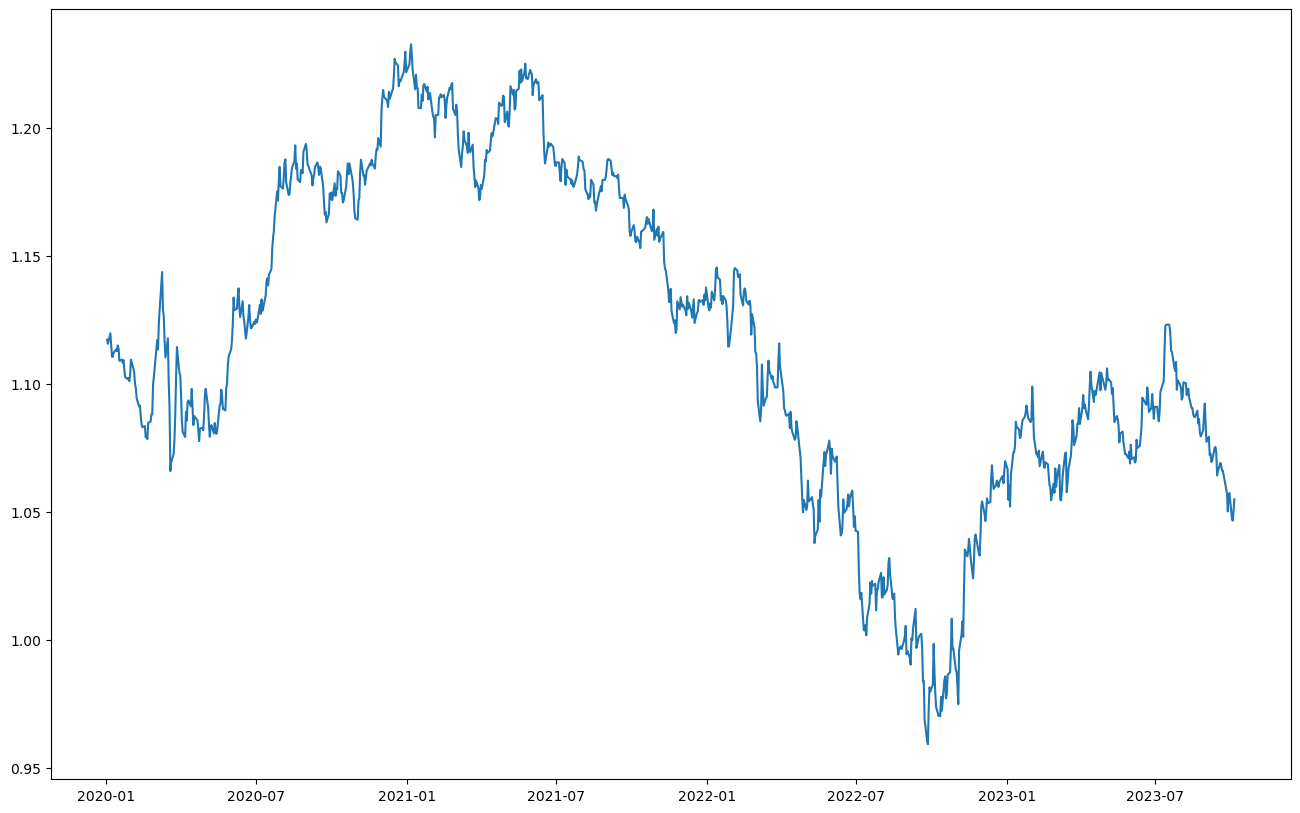

In [7]:
plt.figure(figsize=(16,10))
plt.plot(df)

### This function will seperate the closing prices for each tick. It will basically seperate the data into inputs and labels. 

In [8]:
def classi(dataframe, feature, start_date, end_date, n=3):
    new_df = dataframe.copy()
    new_df = new_df.loc[start_date:end_date]
    
    counter = 0
    for i in new_df.index:
        if counter >= n :
            vals =  new_df.loc[:i][feature].tail(n+1).values
            
            for ij in range(len(vals)):
                if ij+1 <= n:
                    new_df.loc[i, f't{ij+1}'] = vals[ij]
    
                elif ij+1 >= n:
                    new_df.loc[i, f'target'] = vals[ij]
        counter += 1

    X = np.array(new_df[[f't{f+1}' for f in range(n)]].dropna())
    y = np.array(new_df[['target']].dropna())
    
    return new_df, X, y

In [14]:
classi_df, X, y = classi(df, 'close', '2020-01-07', '2023-10-05')

In [15]:
classi_df

,close,t1,t2,t3,target
date,,,,,
2020-01-07,1.11526,NaN,NaN,NaN,NaN
2020-01-08,1.11053,NaN,NaN,NaN,NaN
2020-01-09,1.11051,NaN,NaN,NaN,NaN
2020-01-10,1.11212,1.11526,1.11053,1.11051,1.11212
2020-01-13,1.11338,1.11053,1.11051,1.11212,1.11338
...,...,...,...,...,...
2023-09-29,1.05735,1.05719,1.05015,1.05640,1.05735
2023-10-02,1.04768,1.05015,1.05640,1.05735,1.04768
2023-10-03,1.04655,1.05640,1.05735,1.04768,1.04655


In [16]:
len(X), len(y)

(973, 973)

In [17]:
y_train, y_val, y_test =  y[:int(len(y) * (80/100))], y[int(len(y) * (80/100)):int(len(y) * (90/100))], y[int(len(y) * (90/100)):]
X_train, X_val, X_test =  X[:int(len(X) * (80/100))], X[int(len(X) * (80/100)):int(len(X) * (90/100))], X[int(len(X) * (90/100)):]

In [19]:
p_train = [i for i in range(len(y_train))]
p_val = [i+len(y_train) for i in range(len(y_val))]
p_test = [i+(len(y_val)+len(y_train)) for i in range(len(y_test))]

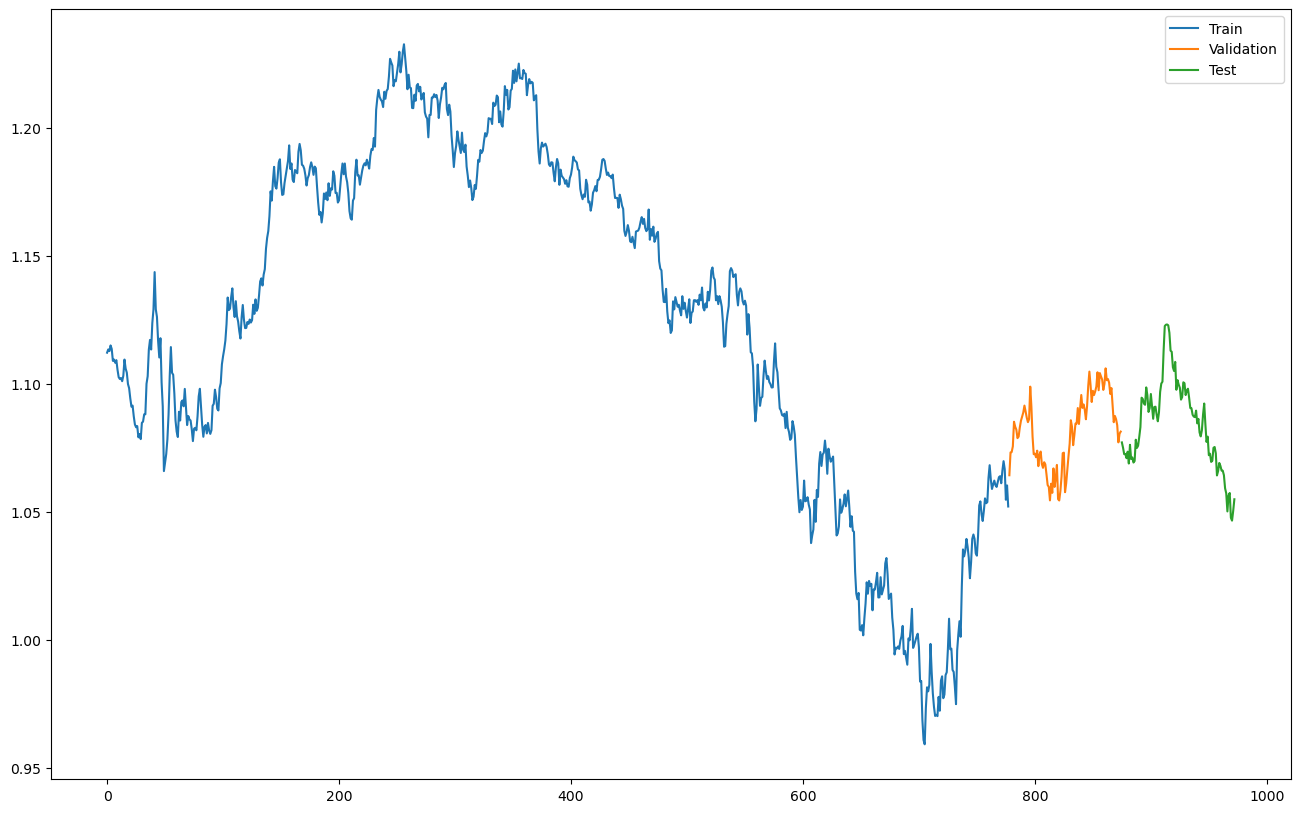

In [20]:
plt.figure(figsize=(16,10))
plt.plot(p_train, y_train)
plt.plot(p_val, y_val)
plt.plot(p_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
25/25 [==============================] - 7s 31ms/step - loss: 0.7777 - mean_absolute_error: 0.8590 - val_loss: 0.1358 - val_mean_absolute_error: 0.3684
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0346 - mean_absolute_error: 0.1568 - val_loss: 0.0017 - val_mean_absolute_error: 0.0401
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0538 - val_loss: 0.0023 - val_mean_absolute_error: 0.0471
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 6.8478e-04 - mean_absolute_error: 0.0217 - val_loss: 3.1591e-04 - val_mean_absolute_error: 0.0164
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 4.9533e-04 - mean_absolute_error: 0.0182 - val_loss: 2.6699e-04 - val_mean_absolute_error: 0.0149
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 4.5358e-04 - mean_absolute_error: 0.0178 - val_loss: 1.7581e-04 - val_mean_absolute_error: 0.01

25/25 [==============================] - 0s 3ms/step


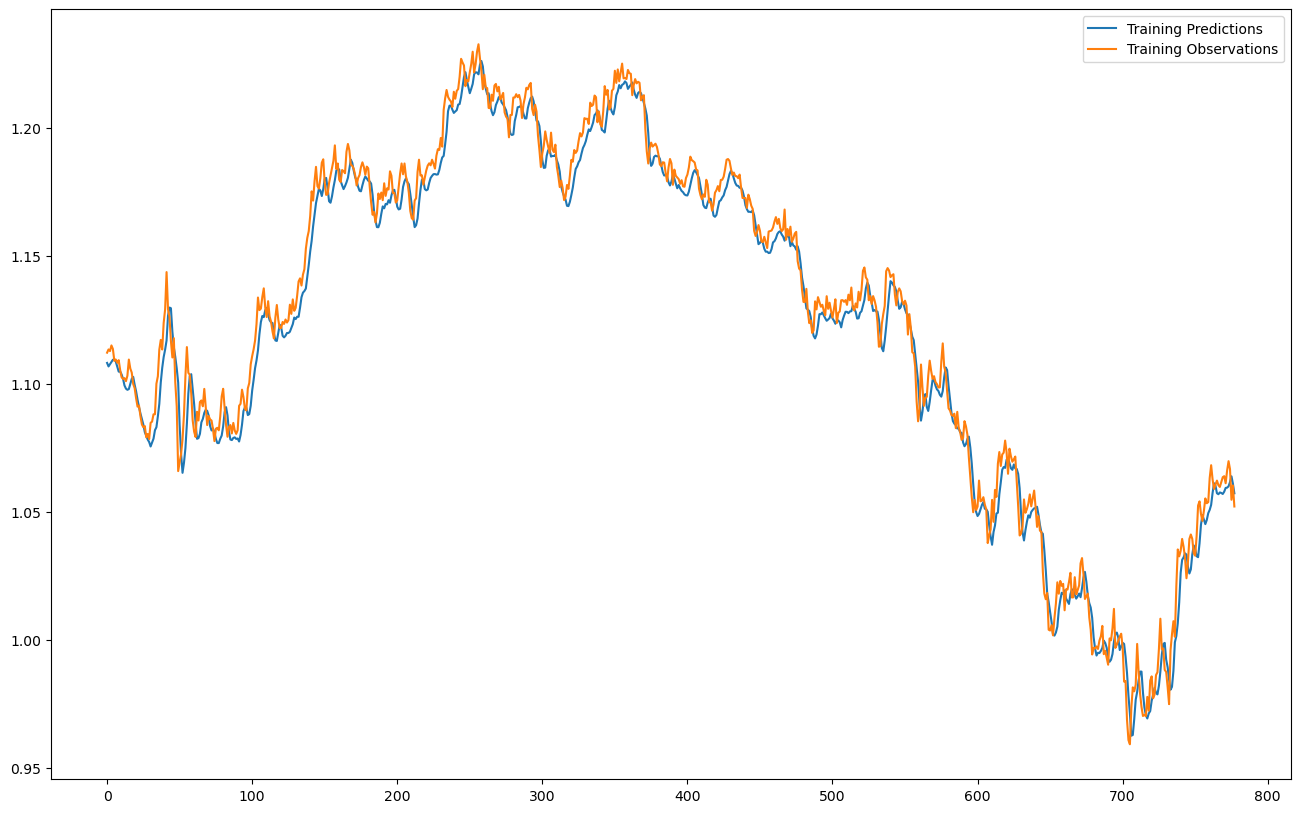

In [23]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(16,10))
plt.plot(p_train, train_predictions)
plt.plot(p_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])